# Introduction/Abstract

Data set from King County Washington.

# Packages Needed/Setting Global Variables

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# EDA

## Questions about the Data

## Import and Clean the Data

In [67]:
# Import the dataset
df = pd.read_csv('kc_house_data.csv')

# Creating a new column for the year sold, dropping origianl date
df['year_sold'] = df.date.apply(lambda x: x[-4:]).astype(int)
df.drop(['date'], axis=1)

# Changing bedroom number for outlier, I think it was a typo of hitting 3 twice
# based off of the sqft
df.at[15856, 'bedrooms'] = 3



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold
15856,2402100895,6/25/2014,640000.0,3,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,2014


In [99]:
df.floors.isna().sum()

0

In [98]:
df.loc[df['floors']>3]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold
10066,1972202010,8/1/2014,435000.0,3,3.00,1440,1350,3.5,0.0,2.0,3,8,1440,0.0,2005,0.0,98103,47.6525,-122.345,1440,1350,2014
11582,3180100023,1/30/2015,544000.0,3,2.50,1760,1755,3.5,0.0,0.0,3,8,1760,0.0,1998,0.0,98105,47.6688,-122.279,1700,1721,2015
14871,8673400177,4/2/2015,525000.0,3,3.00,1730,1074,3.5,0.0,0.0,3,8,1730,0.0,2006,0.0,98107,47.6692,-122.392,1370,1185,2015
15410,1702900664,4/16/2015,479000.0,2,2.50,1730,1037,3.5,0.0,0.0,3,8,1730,0.0,2008,0.0,98118,47.5594,-122.285,1280,1026,2015
18462,1346300150,10/20/2014,3300000.0,8,4.00,7710,11750,3.5,0.0,0.0,5,12,6090,1620.0,1904,0.0,98112,47.6263,-122.314,4210,8325,2014
20292,1972200426,9/18/2014,525000.0,2,2.75,1310,1268,3.5,0.0,0.0,3,8,1310,0.0,2007,0.0,98103,47.6534,-122.355,1350,1288,2014
20756,1972200428,6/25/2014,563500.0,3,2.50,1400,1312,3.5,NaN,0.0,3,8,1400,0.0,2007,NaN,98103,47.6534,-122.355,1350,1312,2014


(array([8.3540e+03, 1.0165e+04, 2.5810e+03, 3.9500e+02, 7.2000e+01,
        2.3000e+01, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  370.,  1687.,  3004.,  4321.,  5638.,  6955.,  8272.,  9589.,
        10906., 12223., 13540.]),
 <a list of 10 Patch objects>)

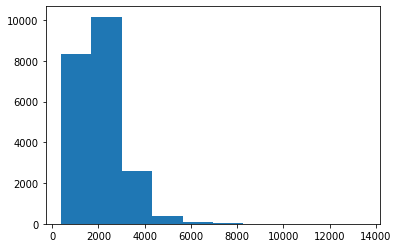

In [88]:
plt.hist(df['sqft_living'])

## Notes

In [7]:
# There is 21 columns, one being the id
categoricals = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
                'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long','year_sold']
continuous = ['sqft_living', 'sqft_lot', 'sqft_above',
              'sqft_basement', 'sqft_living15', 'sqft_lot15']

In [ ]:
# Columns to look at
#        'waterfront', 'view', 'condition', 'grade',
#        'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
#        'lat', 'long', 'sqft_living15', 'sqft_lot15'

# For